In [1]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn; import os; import math
from sklearn import feature_selection, linear_model, grid_search, cross_validation, metrics, ensemble, learning_curve 
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import pickle
import xgboost as xgb
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


In [2]:
#Отбираем ПОСЛЕДНИЕ залоговые билеты со статусом Новый залог за последний год
sql_query = "SELECT [Code] \
      ,[PartnerID] \
      ,IIf([Sex]='M',1,IIf([Sex]='F',0,NULL)) Sex \
      ,[Age] \
      ,[CreditCondition] \
      ,DATEDIFF(MONTH,[LombardFirstDealDate],IssueDate) DateDif \
      ,DATEDIFF(MONTH,[LombardFirstDealDate],GetDate()) LifeT \
      ,[City] \
      ,[SumAmountzb] \
      ,[AVGAmountzb] \
      ,[ZB] \
      ,[Good] \
      ,[PercentGood] \
      ,IIF(PromotionID = 0,0,1) PromotionID \
      ,CONVERT(Float,QntNew)/ZB PercentNew \
      ,CONVERT(Float,[QntPerez])/ZB PercentPerez  \
      ,CONVERT(Float,[QntOSN])/ZB PercentOSN \
      ,CONVERT(Float,[QntBuyUp])/ZB PercentBuyUp \
      ,[AVGDneyZaloga] \
      ,[AVGDneySProshZB] \
      ,[AVGWeightGross] \
      ,[AVGCostPerGram] \
      ,[AVGCost] \
      ,[AVGPercentPerDay] \
      ,[MINPercentPerDay] \
      ,[MAXPercentPerDay] \
      ,[OverPayAmount] \
      ,[PercentAmount]  \
      ,[isGoodZB] \
  FROM [Gold585].[dbo].[CommonTable] a  \
  where IssueDate = (Select MAX(IssueDate) From CommonTable b where a.PartnerID = b.PartnerID) \
  and IssueDate > convert(datetime,'2016-01-01') and IssueDate < convert(datetime,'2018-06-01') and Category in ('Новая cсуда')"
data = pd.read_sql(sql_query,conn)

In [3]:
data.shape

(185069, 29)

In [4]:
data[data['ZB']==1].shape

(78371, 29)

In [5]:
data.head()

,Code,PartnerID,Sex,Age,CreditCondition,DateDif,LifeT,City,SumAmountzb,AVGAmountzb,...,AVGDneySProshZB,AVGWeightGross,AVGCostPerGram,AVGCost,AVGPercentPerDay,MINPercentPerDay,MAXPercentPerDay,OverPayAmount,PercentAmount,isGoodZB
0,930003901705,3773,1.0,39,0,0,32,61AE0523815817D8085C4290A322AEACA17509208912BE...,810.0,810.000000,...,0,0.600,1350.000000,810.000000,0.3000,0.30,0.30,0.0,0.0,0
1,620001505248,2318,1.0,39,2,23,32,39369AE2544E3327043BEE6D7C268073257C387E22F0F4...,58644.0,5864.399902,...,77,4.539,1429.956909,6487.700195,0.4500,0.45,0.45,0.0,0.0,1
2,930003902020,3892,1.0,38,0,0,32,5D40111A3597520A0AD3418E6C1968A2FE4EE78C518CD6...,1100.0,1100.000000,...,0,0.860,1350.000000,1161.000000,0.4500,0.45,0.45,0.0,0.0,0
3,620001081731,293453,1.0,57,3,50,64,2227A0224C18DF73B5A6CCAD33BD9119EB219F726FE844...,114175.0,6009.210449,...,85,5.301,1161.580322,6068.331543,0.3121,0.25,0.39,0.0,0.0,1
4,930003908375,1694,1.0,42,1,0,32,14D2518F66BDEA9CFB1D48B258941D9A90657FE356E0CE...,7250.0,3625.000000,...,3,2.715,1349.924438,3665.000000,0.4500,0.45,0.45,0.0,0.0,0


In [6]:
print(np.percentile(data['ZB'],99)) # у 99 процентов посетителей < 51 ЗБ

51.0


In [7]:
print(np.percentile(data['ZB'],95)) # у 99 процентов посетителей < 51 ЗБ

22.0


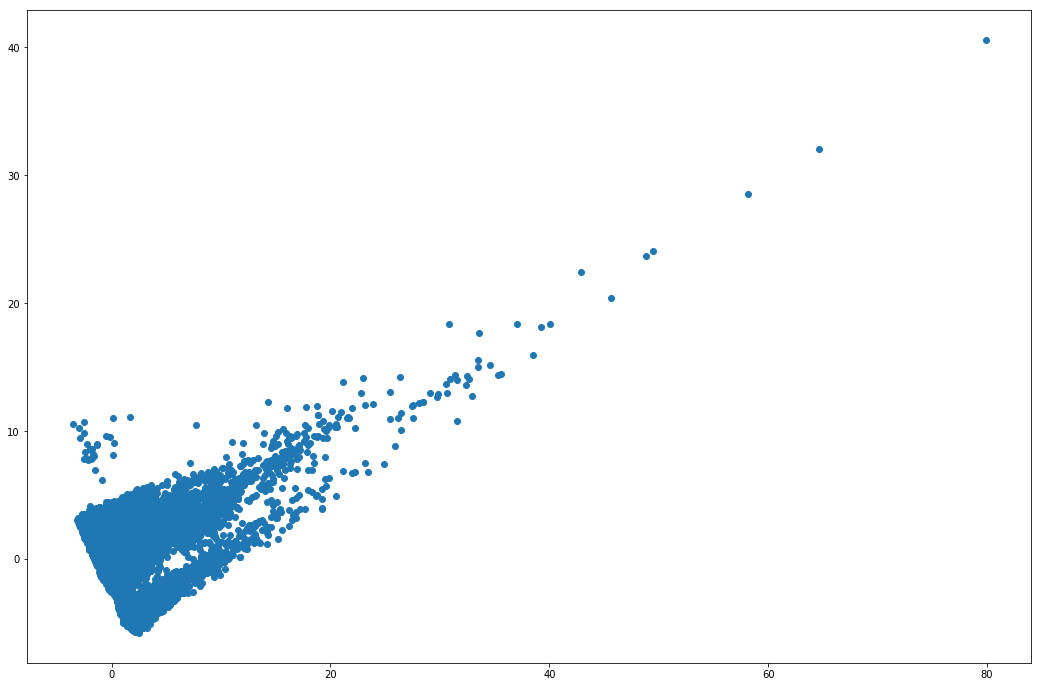

In [8]:
df = data[(data['ZB']==1) ].fillna(0)
df.reset_index(drop=True,inplace = True)
target=df.drop(['Code','PartnerID','City','isGoodZB'], axis=1)
target = pd.get_dummies(target, columns = ['CreditCondition'])
X = StandardScaler().fit_transform(target)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

0.38141568819311167
0.3840517451572916
0.25249807203301056
0.275007087784903
0.2798559830768203
0.28306090594839395


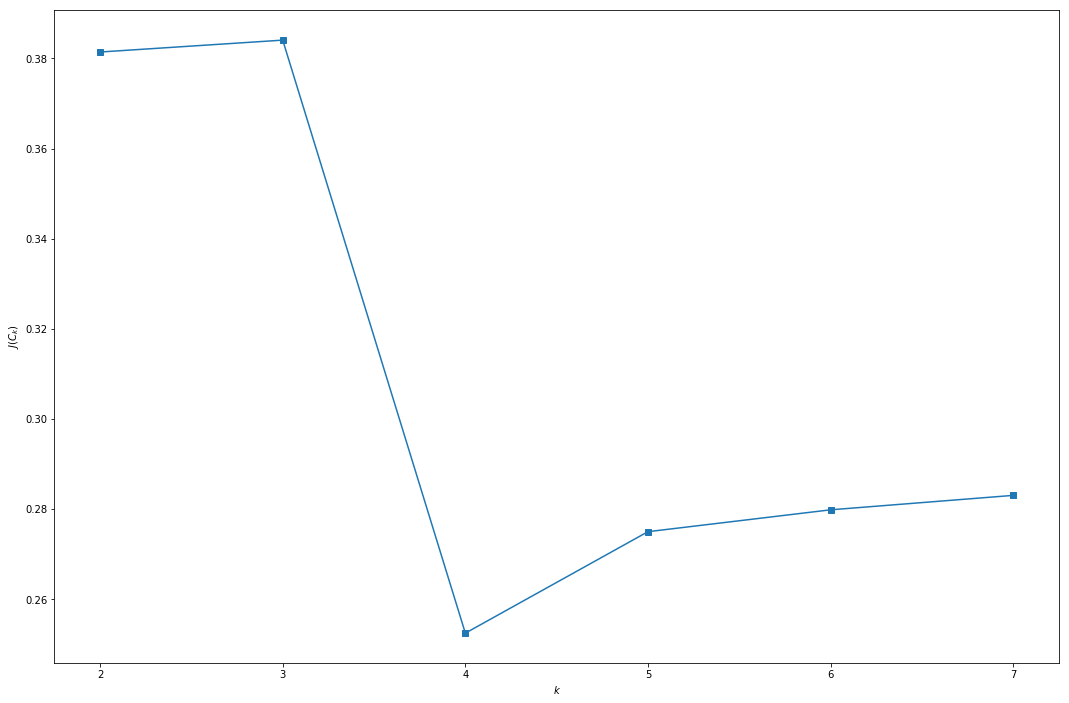

In [10]:
# с процентами новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X)
    labels = kmeans.predict(X)
    a= silhouette_samples_memory_saving(X, kmeans.labels_)
    #a= silhouette_score(X, kmeans.labels_)
    mas.append(a)
    print(a)

plt.plot(range(2, 8), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

# Оптимальное количество кластеров 

Wall time: 7.69 s


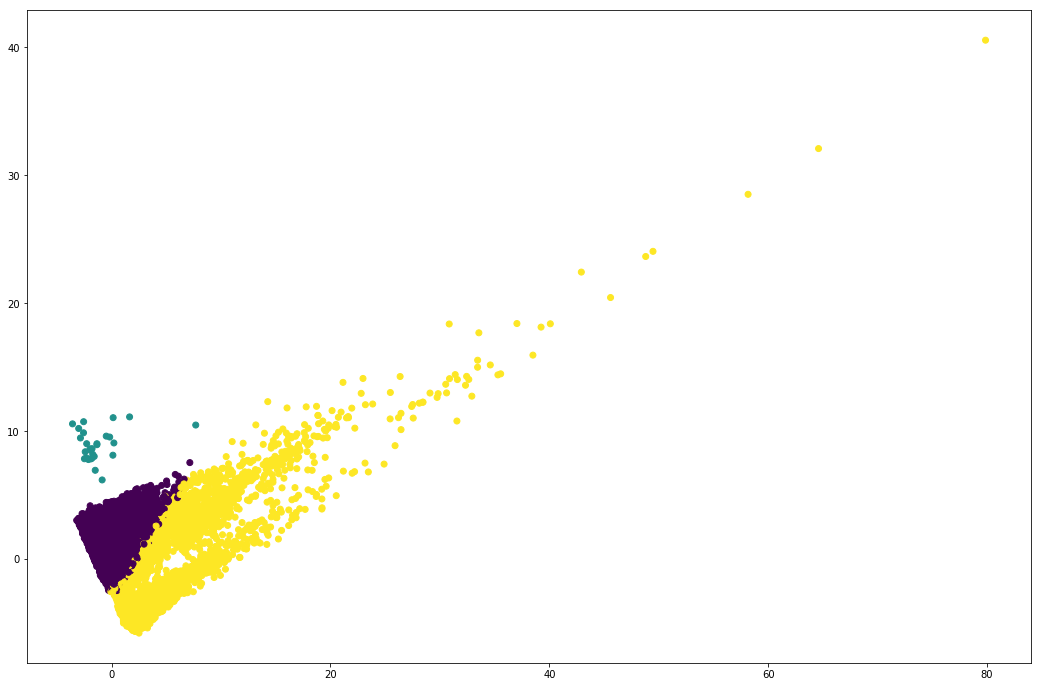

In [11]:
%%time
kmeans = KMeans(n_clusters= 3, random_state=1,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [13]:
print(df.shape[0])
print(df[df['labels']==0].shape[0])
print(df[df['labels']==1].shape[0])
print(df[df['labels']==2].shape[0])
#print(df[df['labels']==3].shape[0])
#print(df[df['labels']==4].shape[0])
#print(df[df['labels']==5].shape[0])
#print(df[df['labels']==6].shape[0])

78371
67453
29
10889


In [12]:
pd.concat([df[df['labels']==0].describe().T['50%'],df[df['labels']==0].describe().T['mean'],df[df['labels']==0].describe().T['std'], \
           df[df['labels']==1].describe().T['50%'],df[df['labels']==1].describe().T['mean'],df[df['labels']==1].describe().T['std'], \
           df[df['labels']==2].describe().T['50%'],df[df['labels']==2].describe().T['mean'],df[df['labels']==2].describe().T['std'], \
 #          df[df['labels']==3].describe().T['50%'],df[df['labels']==3].describe().T['mean'],df[df['labels']==3].describe().T['std'], \
 #          df[df['labels']==4].describe().T['50%'],df[df['labels']==4].describe().T['mean'],df[df['labels']==4].describe().T['std'], \
 #          df[df['labels']==5].describe().T['50%'],df[df['labels']==5].describe().T['mean'],df[df['labels']==5].describe().T['std'], \
 #          df[df['labels']==6].describe().T['50%'],df[df['labels']==6].describe().T['mean'],df[df['labels']==6].describe().T['std'], \
 #          df[df['labels']==7].describe().T['50%'],df[df['labels']==7].describe().T['mean'],df[df['labels']==7].describe().T['std'], \
 #          df[df['labels']==8].describe().T['50%'],df[df['labels']==8].describe().T['mean'],df[df['labels']==8].describe().T['std'], \
 #          df[df['labels']==9].describe().T['50%'],df[df['labels']==9].describe().T['mean'],df[df['labels']==9].describe().T['std'], \
           ],axis=1).to_csv('Last 1 ZB - 3kl from 2016.csv')

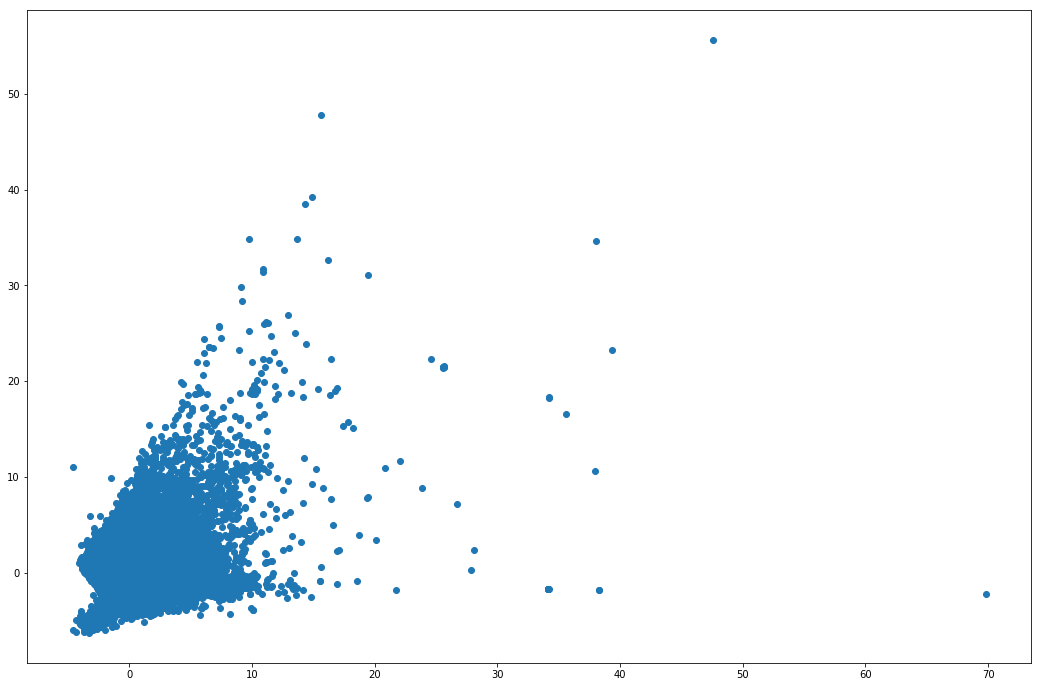

In [14]:
df = data[(data['ZB']>1) ].fillna(0)
df.reset_index(drop=True,inplace = True)
target=df.drop(['Code','PartnerID','City','isGoodZB'], axis=1)
target = pd.get_dummies(target, columns = ['CreditCondition'])
X = StandardScaler().fit_transform(target)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

0.1407717222638881
0.16349240358876843
0.13019483132312615
0.14228285509715488
0.10278390717777419
0.12670505092979475
0.1808781053061607
0.1827930748546917
0.1961260759164896


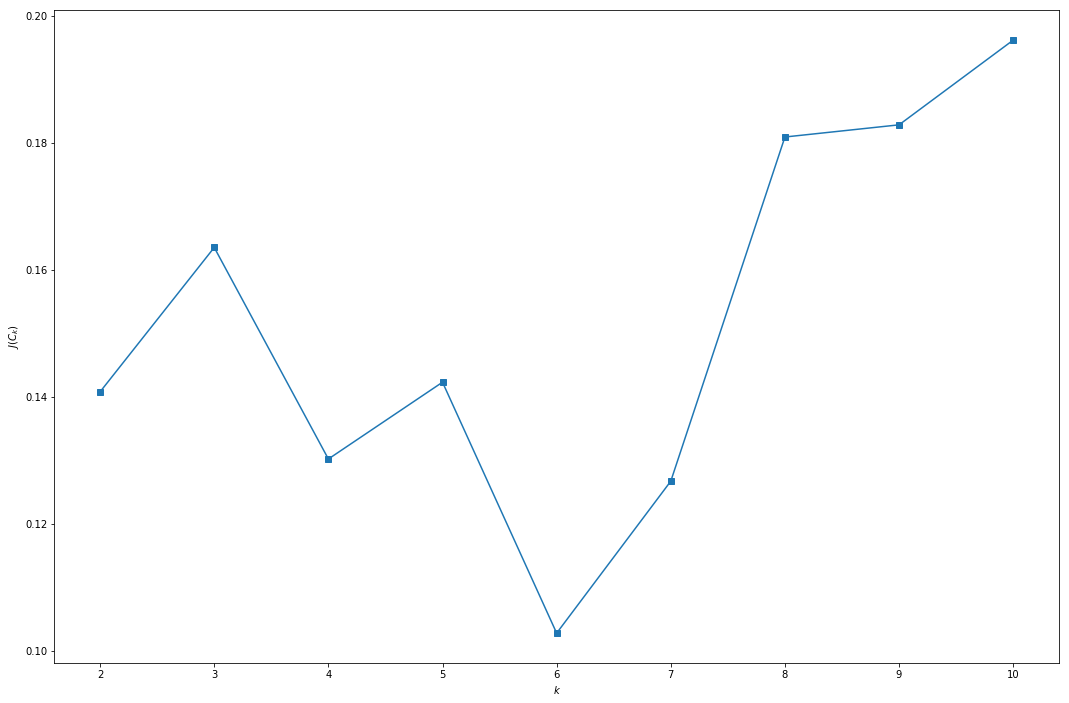

In [15]:
# с процентами новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X)
    labels = kmeans.predict(X)
    a= silhouette_samples_memory_saving(X, kmeans.labels_)
    #a= silhouette_score(X, kmeans.labels_)
    mas.append(a)
    print(a)

plt.plot(range(2, 11), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

# Оптимальное количество кластеров 

In [9]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils import check_X_y
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster.unsupervised import check_number_of_labels

def silhouette_samples_memory_saving(X, labels, metric='euclidean', **kwds):
    X, labels = check_X_y(X, labels, accept_sparse=['csc', 'csr'])
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    check_number_of_labels(len(le.classes_), X.shape[0])

    unique_labels = le.classes_
    n_samples_per_label = np.bincount(labels, minlength=len(unique_labels))

    # For sample i, store the mean distance of the cluster to which
    # it belongs in intra_clust_dists[i]
    intra_clust_dists = np.zeros(X.shape[0], dtype=X.dtype)

    # For sample i, store the mean distance of the second closest
    # cluster in inter_clust_dists[i]
    inter_clust_dists = np.inf + intra_clust_dists

    for curr_label in range(len(unique_labels)):

        # Find inter_clust_dist for all samples belonging to the same
        # label.
        mask = labels == curr_label

        # Leave out current sample.
        n_samples_curr_lab = n_samples_per_label[curr_label] - 1
        if n_samples_curr_lab != 0:
            intra_distances = pairwise_distances(X[mask, :], metric=metric, **kwds)
            intra_clust_dists[mask] = np.sum(intra_distances, axis=1) / n_samples_curr_lab

        # Now iterate over all other labels, finding the mean
        # cluster distance that is closest to every sample.
        for other_label in range(len(unique_labels)):
            if other_label != curr_label:
                other_mask = labels == other_label
                inter_distances = pairwise_distances(X[mask, :], X[other_mask, :], metric=metric, **kwds)
                other_distances = np.mean(inter_distances, axis=1)
                inter_clust_dists[mask] = np.minimum(inter_clust_dists[mask], other_distances)

    sil_samples = inter_clust_dists - intra_clust_dists
    sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
    # score 0 for clusters of size 1, according to the paper
    sil_samples[n_samples_per_label.take(labels) == 1] = 0

    return np.mean(sil_samples)

In [34]:
X1 = pd.DataFrame(X).sample(50000)

In [35]:
X1.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
59012,1.012077,-0.749261,-0.128523,-0.465966,-0.324201,-0.314070,-1.187007,2.655217,0.573358,-0.462607,...,-0.798783,1.034847,-0.524208,-0.464243,-0.226507,-0.162894,-0.193624,-0.065765,-0.090821,-0.031307
72680,-0.543320,-0.643298,-0.103464,-0.307748,-0.195793,-0.104395,1.073056,-0.376617,0.573358,-0.462607,...,1.251905,-0.966326,1.907639,-0.464243,-0.226507,-0.162894,-0.193624,-0.065765,-0.090821,-0.031307
70352,-0.952635,-0.749261,-0.129791,-0.506328,-0.324201,-0.244178,1.073056,-0.376617,0.573358,-0.462607,...,-0.798783,1.034847,-0.524208,-0.464243,-0.226507,-0.162894,-0.193624,-0.065765,-0.090821,-0.031307
42676,-0.134005,0.522297,0.111163,-0.070997,0.510451,0.664413,1.073056,-0.376617,-0.903130,1.293506,...,1.251905,-0.966326,-0.524208,-0.464243,-0.226507,-0.162894,5.164655,-0.065765,-0.090821,-0.031307
66856,-0.543320,0.522297,0.012072,-0.354702,0.703063,0.874088,1.073056,-0.376617,-0.946556,1.345156,...,-0.798783,-0.966326,-0.524208,2.154044,-0.226507,-0.162894,-0.193624,-0.065765,-0.090821,-0.031307


0.18451326908863
0.16869978885847253
0.1610826316026968
0.1615134527630441
0.17277753579750432
0.12731452365428206
0.20970526807288062
0.2242931778431883
0.22896609670117454
0.18675544231112537
0.2036590345072489
0.20429758453710015
0.19021827139704459


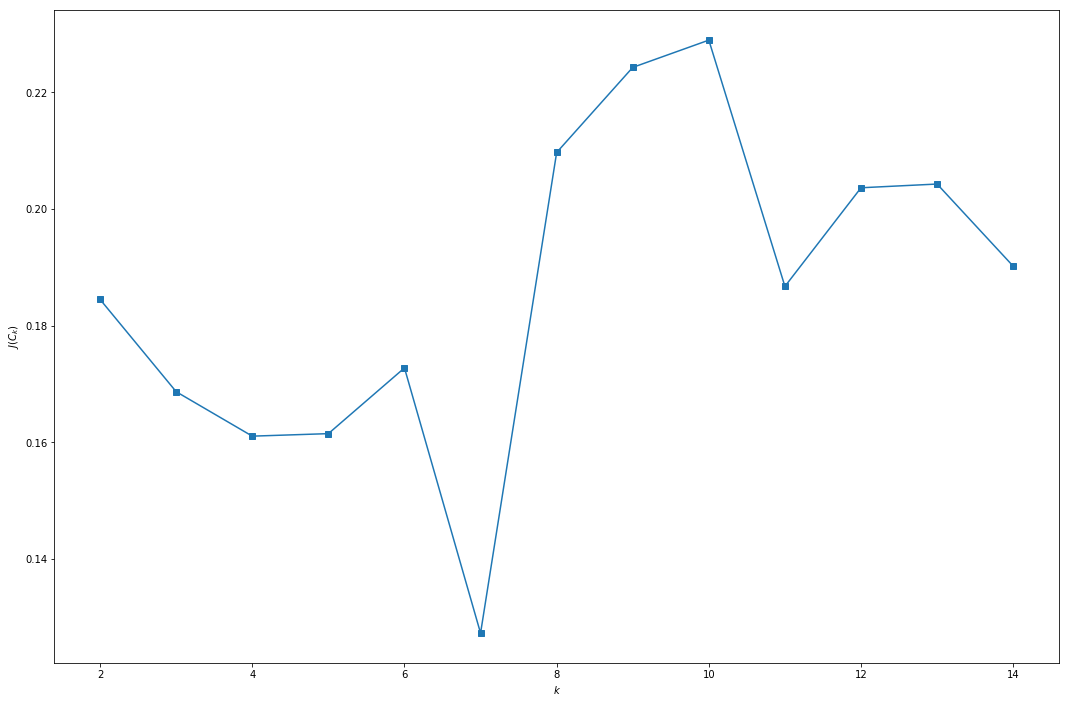

In [36]:
# с процентами новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X1)
    labels = kmeans.predict(X1)
    #a= silhouette_samples_memory_saving(X1, kmeans.labels_)
    a= silhouette_score(X1, kmeans.labels_)
    mas.append(a)
    print(a)

plt.plot(range(2, 15), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

# Оптимальное количество кластеров 10

0.18281843516879726
0.1801535686141714
0.14217932567309802
0.1481161301950629
0.18591482870565035
0.20491210371801666
0.21246732872895144
0.14625667065811737
0.1809366051150837
0.19211846141794134
0.21919571358635034
0.22277378596397307
0.22548150491183028


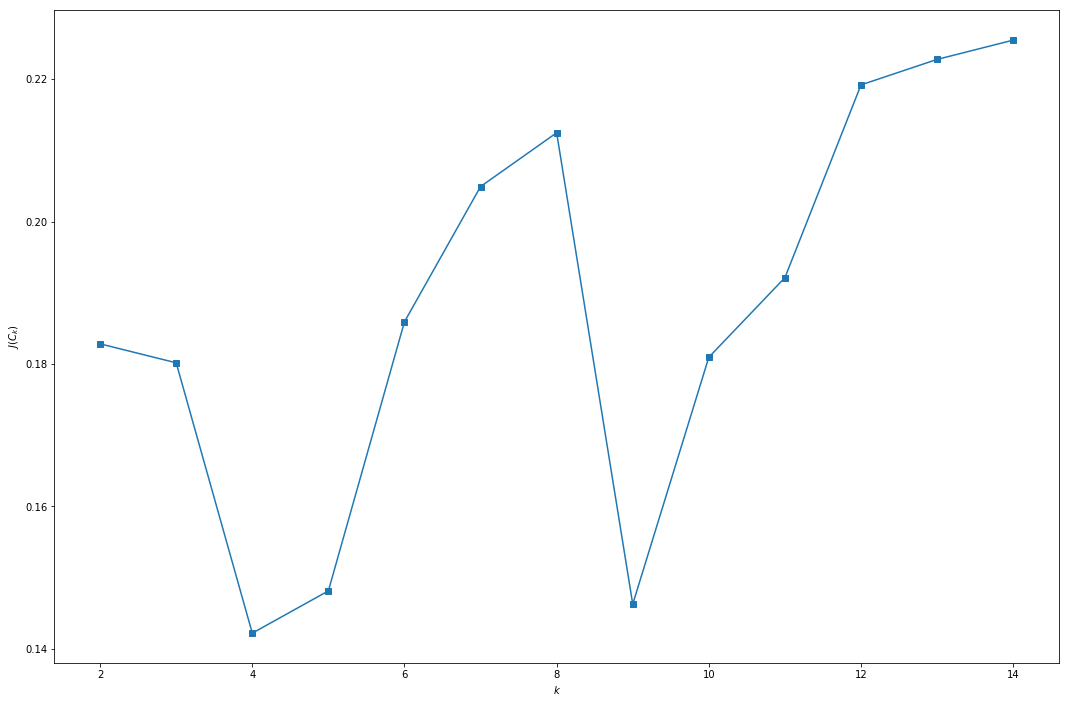

In [17]:
#не отобразились проценты новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X1)
    labels = kmeans.predict(X1)
    #a= silhouette_samples_memory_saving(X1, kmeans.labels_)
    a= silhouette_score(X1, kmeans.labels_)
    mas.append(a)
    print(a)

plt.plot(range(2, 15), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

# Оптимальное количество кластеров 8

1659.6095926452101
1573.6331399464796
1515.5514487073806
1466.9274703146743
1427.5200928640847
1378.735778026563
1335.3200411930477
1301.8843739752256
1259.9291301259848
1231.742996579982
1195.894957110882
1148.531906891689
1118.9423358885824
1102.1569579560019


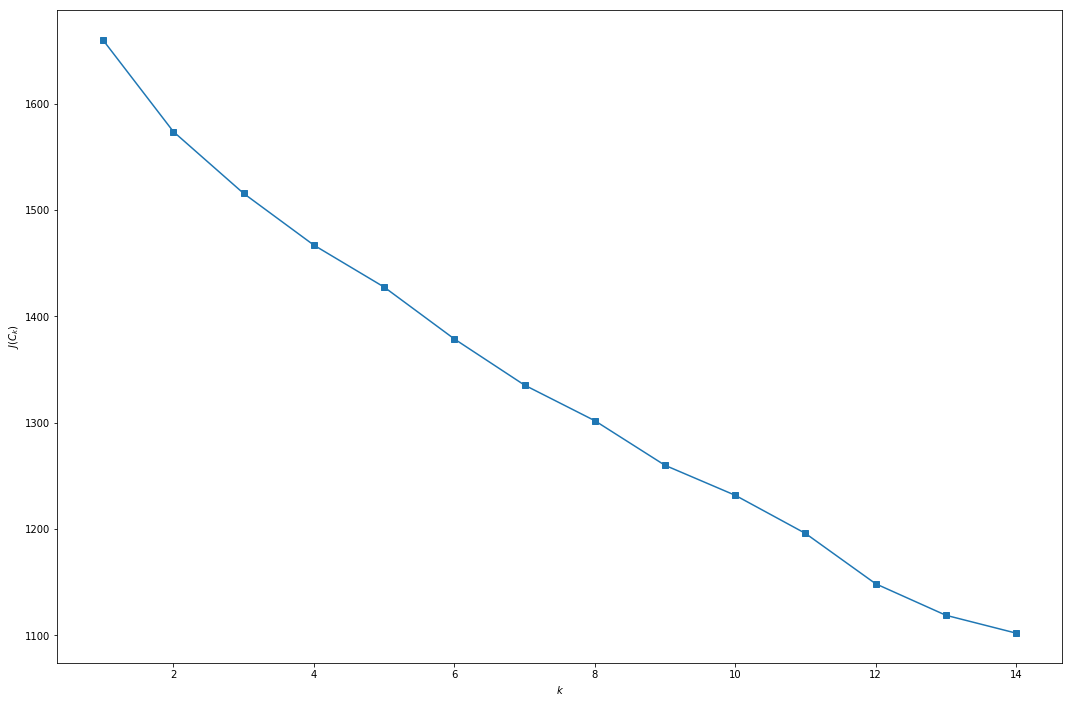

In [18]:
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    a = np.sqrt(kmeans.inertia_)
    inertia.append(a)
    print(a)
    
plt.plot(range(1, 15), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
# возьмем 2 класстера

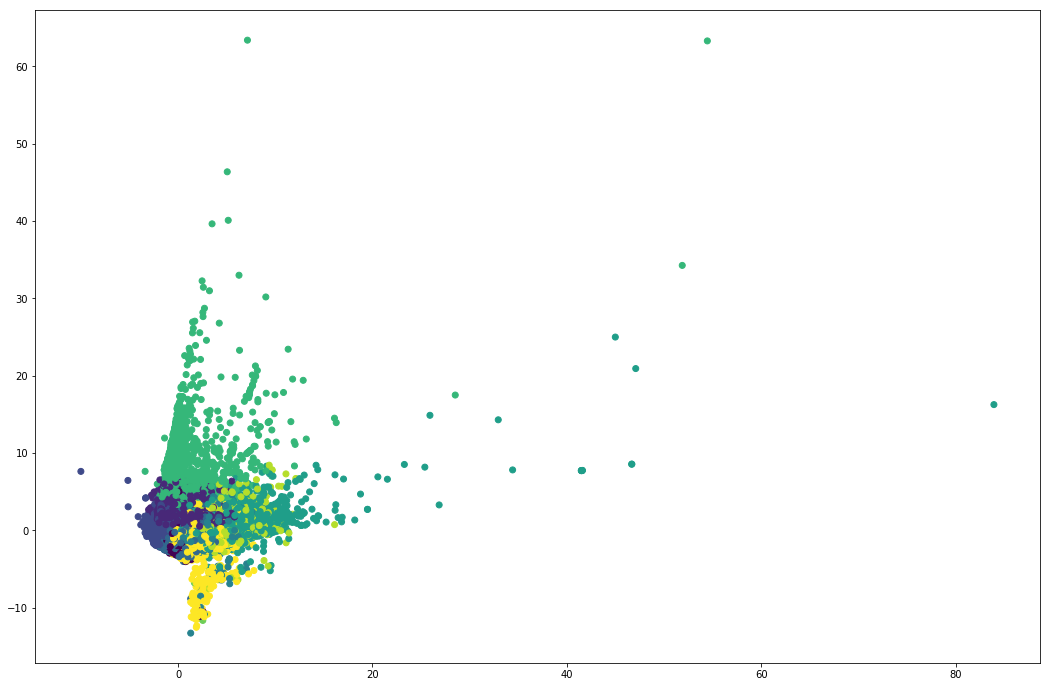

In [38]:
kmeans = KMeans(n_clusters=10, random_state=1,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

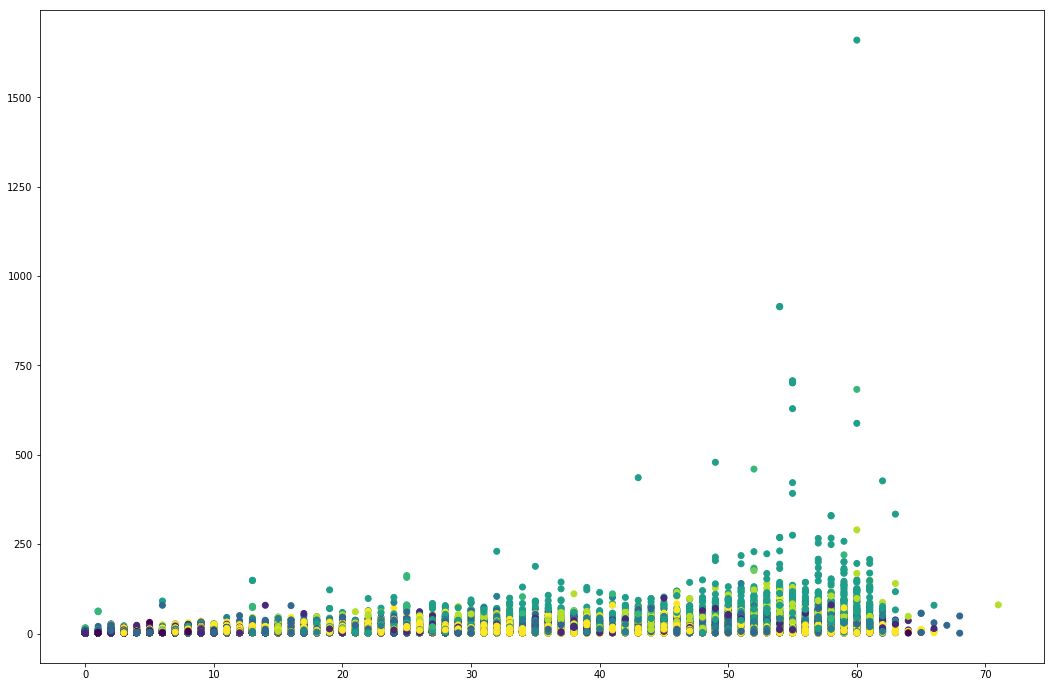

In [39]:
plt.scatter(df['LifeTimeMonth'], df['ZB'],c =df['labels'])

In [40]:
print(df.shape[0])
print(df[df['labels']==0].shape[0])
print(df[df['labels']==1].shape[0])
print(df[df['labels']==2].shape[0])
print(df[df['labels']==3].shape[0])
print(df[df['labels']==4].shape[0])
print(df[df['labels']==5].shape[0])
print(df[df['labels']==6].shape[0])
print(df[df['labels']==7].shape[0])
print(df[df['labels']==8].shape[0])
print(df[df['labels']==9].shape[0])

94976
4217
11694
32432
17040
4573
3854
1677
409
2434
16646


In [43]:
pd.concat([df[df['labels']==0].describe().T['50%'],df[df['labels']==0].describe().T['mean'],df[df['labels']==0].describe().T['std'], \
           df[df['labels']==1].describe().T['50%'],df[df['labels']==1].describe().T['mean'],df[df['labels']==1].describe().T['std'], \
           df[df['labels']==2].describe().T['50%'],df[df['labels']==2].describe().T['mean'],df[df['labels']==2].describe().T['std'], \
           df[df['labels']==3].describe().T['50%'],df[df['labels']==3].describe().T['mean'],df[df['labels']==3].describe().T['std'], \
           df[df['labels']==4].describe().T['50%'],df[df['labels']==4].describe().T['mean'],df[df['labels']==4].describe().T['std'], \
           df[df['labels']==5].describe().T['50%'],df[df['labels']==5].describe().T['mean'],df[df['labels']==5].describe().T['std'], \
           df[df['labels']==6].describe().T['50%'],df[df['labels']==6].describe().T['mean'],df[df['labels']==6].describe().T['std'], \
           df[df['labels']==7].describe().T['50%'],df[df['labels']==7].describe().T['mean'],df[df['labels']==7].describe().T['std'], \
           df[df['labels']==8].describe().T['50%'],df[df['labels']==8].describe().T['mean'],df[df['labels']==8].describe().T['std'], \
           df[df['labels']==9].describe().T['50%'],df[df['labels']==9].describe().T['mean'],df[df['labels']==9].describe().T['std'], \
           ],axis=1).to_csv('Client-lastZB-last Year-2.csv')

In [44]:
#Отбираем ПОСЛЕДНИЕ залоговые билеты со статусом Новый залог c 2015 года
sql_query = "SELECT [Code] \
      ,[PartnerID] \
      ,IIf([Sex]='M',1,IIf([Sex]='F',0,NULL)) Sex \
      ,[Age] \
      ,[CreditCondition] \
      ,DATEDIFF(MONTH,[LombardFirstDealDate],IssueDate) LifeTimeMonth \
      ,[City] \
      ,[SumAmountzb] \
      ,[AVGAmountzb] \
      ,[ZB] \
      ,[Good] \
      ,[PercentGood] \
	  ,IIF(PromotionID = 0,0,1) PromotionID \
      ,CONVERT(Float,QntNew)/ZB PercentNew \
      ,CONVERT(Float,[QntPerez])/ZB PercentPerez  \
      ,CONVERT(Float,[QntOSN])/ZB PercentOSN \
      ,CONVERT(Float,[QntBuyUp])/ZB PercentBuyUp \
      ,[AVGDneyZaloga] \
      ,[AVGDneySProshZB] \
      ,[AVGWeightGross] \
      ,[AVGCostPerGram] \
      ,[AVGCost] \
      ,[AVGPercentPerDay] \
      ,[MINPercentPerDay] \
      ,[MAXPercentPerDay] \
      ,[OverPayAmount] \
      ,[PercentAmount]  \
      ,[isGoodZB] \
  FROM [Gold585].[dbo].[CommonTable] a  \
  where IssueDate = (Select MAX(IssueDate) From CommonTable b where a.PartnerID = b.PartnerID) \
  and IssueDate > convert(datetime,'2015-01-01') and IssueDate < convert(datetime,'2018-06-01') and Category in ('Новая cсуда')"
data = pd.read_sql(sql_query,conn)

In [45]:
data.shape

(309066, 28)

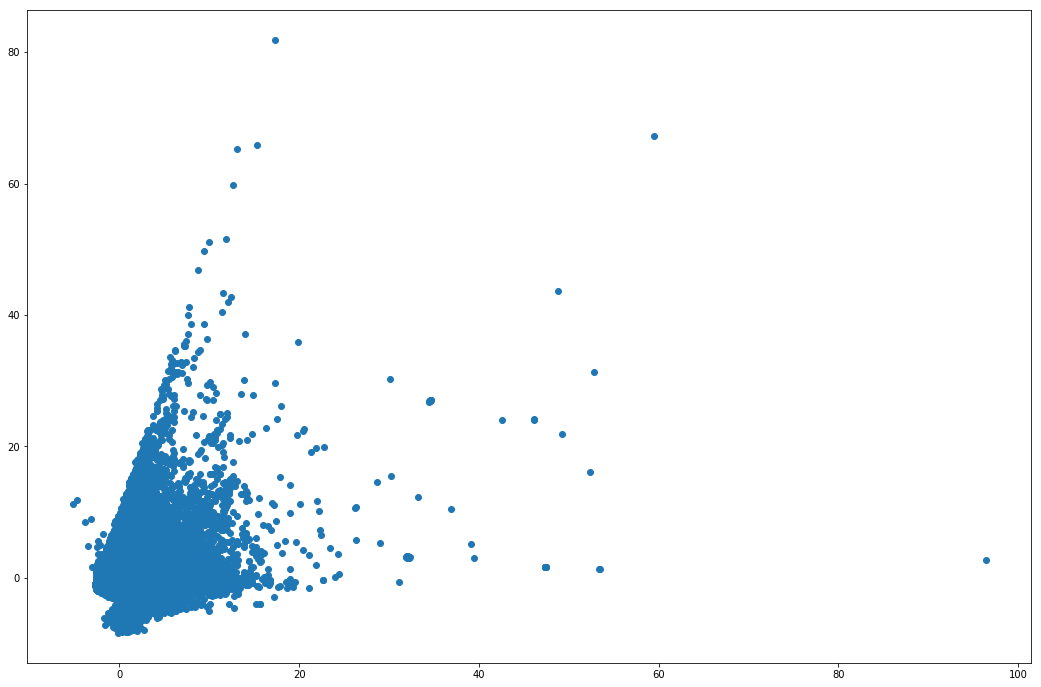

In [46]:
df = data.fillna(0)
target=df.drop(['Code','PartnerID','City','isGoodZB'], axis=1)
target = pd.get_dummies(target, columns = ['Sex','CreditCondition'])
X = StandardScaler().fit_transform(target)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

0.2104223162177499
0.15891109286012356
0.13192211865149497
0.1211264099267392
0.13534115802873953
0.15550987894420754
0.18414085041095604
0.16541338036087863
0.17774247148871855
0.17077547985219976
0.18152684693646903
0.1855129182247441
0.20600036507171662


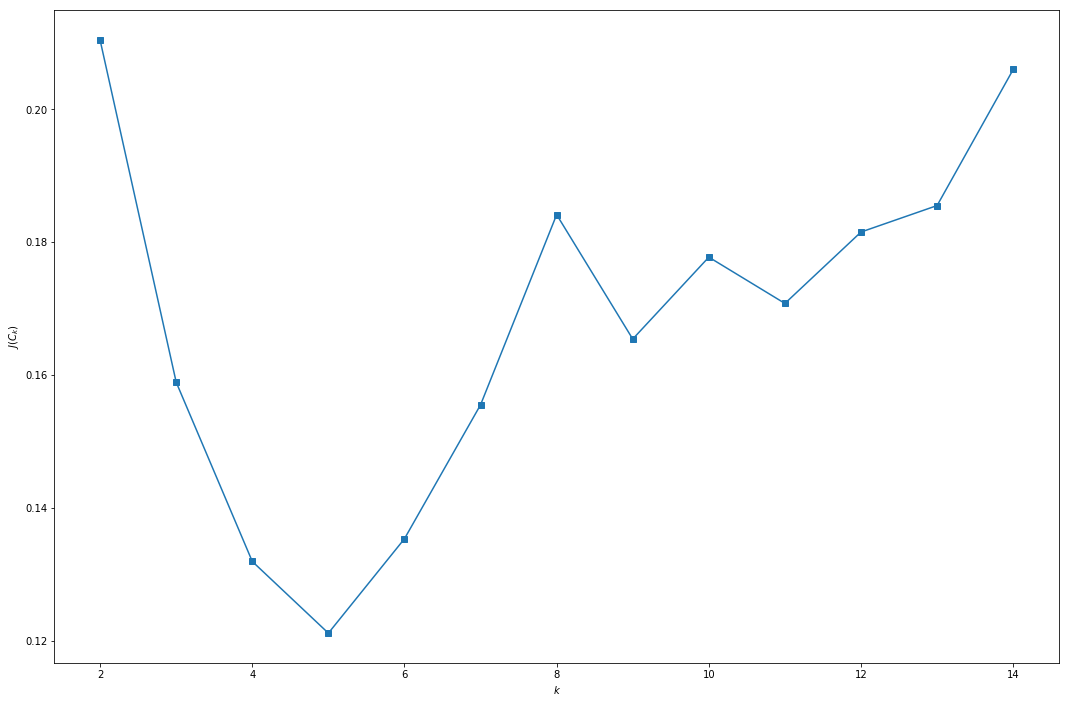

In [47]:
X1 = pd.DataFrame(X).sample(50000)

# с процентами новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X1)
    labels = kmeans.predict(X1)
    #a= silhouette_samples_memory_saving(X1, kmeans.labels_)
    a= silhouette_score(X1, kmeans.labels_)
    mas.append(a)
    print(a)

plt.plot(range(2, 15), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

# Оптимальное количество кластеров 8

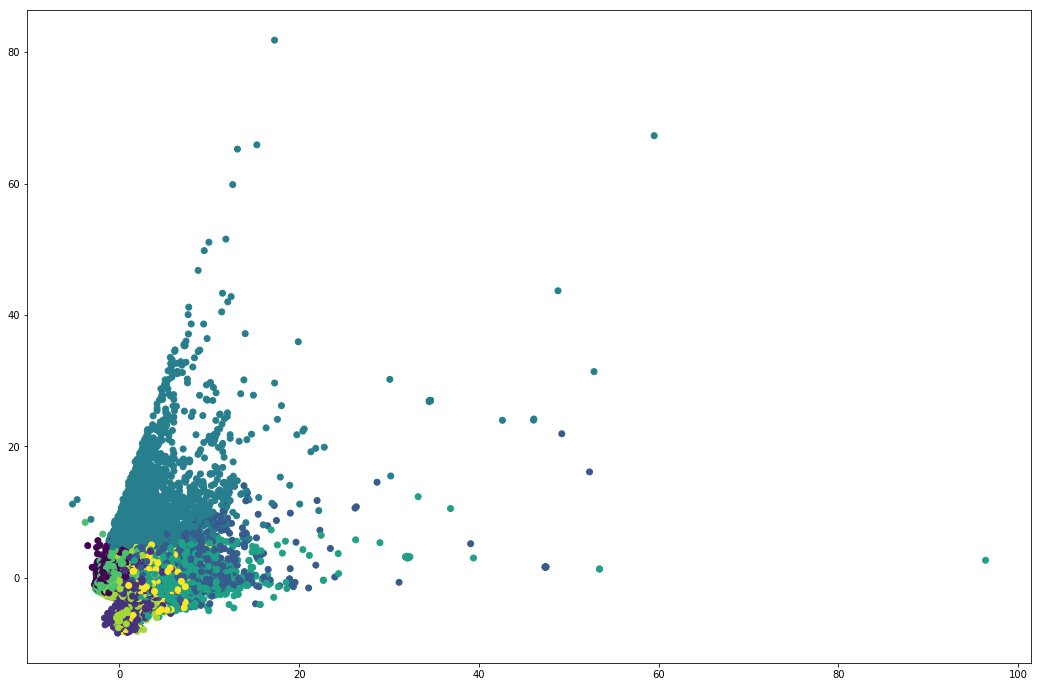

In [49]:
kmeans = KMeans(n_clusters=8, random_state=1,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [50]:
print(df.shape[0])
print(df[df['labels']==0].shape[0])
print(df[df['labels']==1].shape[0])
print(df[df['labels']==2].shape[0])
print(df[df['labels']==3].shape[0])
print(df[df['labels']==4].shape[0])
print(df[df['labels']==5].shape[0])
print(df[df['labels']==6].shape[0])
print(df[df['labels']==7].shape[0])
#print(df[df['labels']==8].shape[0])
#print(df[df['labels']==9].shape[0])

309066
66324
48160
8347
5226
15369
100396
47917
17327


In [51]:
pd.concat([df[df['labels']==0].describe().T['50%'],df[df['labels']==0].describe().T['mean'],df[df['labels']==0].describe().T['std'], \
           df[df['labels']==1].describe().T['50%'],df[df['labels']==1].describe().T['mean'],df[df['labels']==1].describe().T['std'], \
           df[df['labels']==2].describe().T['50%'],df[df['labels']==2].describe().T['mean'],df[df['labels']==2].describe().T['std'], \
           df[df['labels']==3].describe().T['50%'],df[df['labels']==3].describe().T['mean'],df[df['labels']==3].describe().T['std'], \
           df[df['labels']==4].describe().T['50%'],df[df['labels']==4].describe().T['mean'],df[df['labels']==4].describe().T['std'], \
           df[df['labels']==5].describe().T['50%'],df[df['labels']==5].describe().T['mean'],df[df['labels']==5].describe().T['std'], \
           df[df['labels']==6].describe().T['50%'],df[df['labels']==6].describe().T['mean'],df[df['labels']==6].describe().T['std'], \
           df[df['labels']==7].describe().T['50%'],df[df['labels']==7].describe().T['mean'],df[df['labels']==7].describe().T['std'], \
 #          df[df['labels']==8].describe().T['50%'],df[df['labels']==8].describe().T['mean'],df[df['labels']==8].describe().T['std'], \
 #          df[df['labels']==9].describe().T['50%'],df[df['labels']==9].describe().T['mean'],df[df['labels']==9].describe().T['std'], \
           ],axis=1).to_csv('Client-lastZB-from 2015.csv')

In [2]:

# ПРЕДпоследний ЗБ
sql_query = "SELECT [Code] \
      ,[PartnerID]  \
      ,IIf([Sex]='M',1,IIf([Sex]='F',0,NULL)) Sex \
      ,[Age] \
      ,[CreditCondition] \
      ,DATEDIFF(MONTH,[LombardFirstDealDate],IssueDate) LifeTimeMonth \
      ,[City] \
      ,[SumAmountzb] \
      ,[AVGAmountzb] \
      ,[ZB] \
      ,[Good] \
      ,[PercentGood] \
      ,IIF(PromotionID = 0,0,1) PromotionID \
      ,CONVERT(Float,QntNew)/ZB PercentNew \
      ,CONVERT(Float,[QntPerez])/ZB PercentPerez  \
      ,CONVERT(Float,[QntOSN])/ZB PercentOSN \
      ,CONVERT(Float,[QntBuyUp])/ZB PercentBuyUp \
      ,[AVGDneyZaloga] \
      ,[AVGDneySProshZB] \
      ,[AVGWeightGross] \
      ,[AVGCostPerGram] \
      ,[AVGCost] \
      ,[AVGPercentPerDay] \
      ,[MINPercentPerDay] \
      ,[MAXPercentPerDay] \
      ,[OverPayAmount] \
      ,[PercentAmount]  \
      ,[isGoodZB] \
	  ,[BudetSledVisit3M] \
      ,[BudetSledVisit6M] \
      ,[BudetSledVisit12M] \
      ,[BudetSledVisit] \
      ,[BudetPerezalog] \
  FROM [Gold585].[dbo].[CommonTable] a   \
  where IssueDateTime = (Select MAX(IssueDateTime) From CommonTable b where a.PartnerID = b.PartnerID \
  and b.IssueDateTime < (Select MAX(IssueDateTime) From CommonTable c where c.PartnerID = b.PartnerID \
  and c.IssueDate > convert(datetime,'2017-10-01') and c.IssueDate < convert(datetime,'2018-06-01'))) \
  and Category in ('Новая cсуда') and IssueDate > convert(datetime,'2015-01-01') and IssueDate < convert(datetime,'2018-06-01')"

data = pd.read_sql(sql_query,conn)

In [3]:
data.shape

(118651, 33)

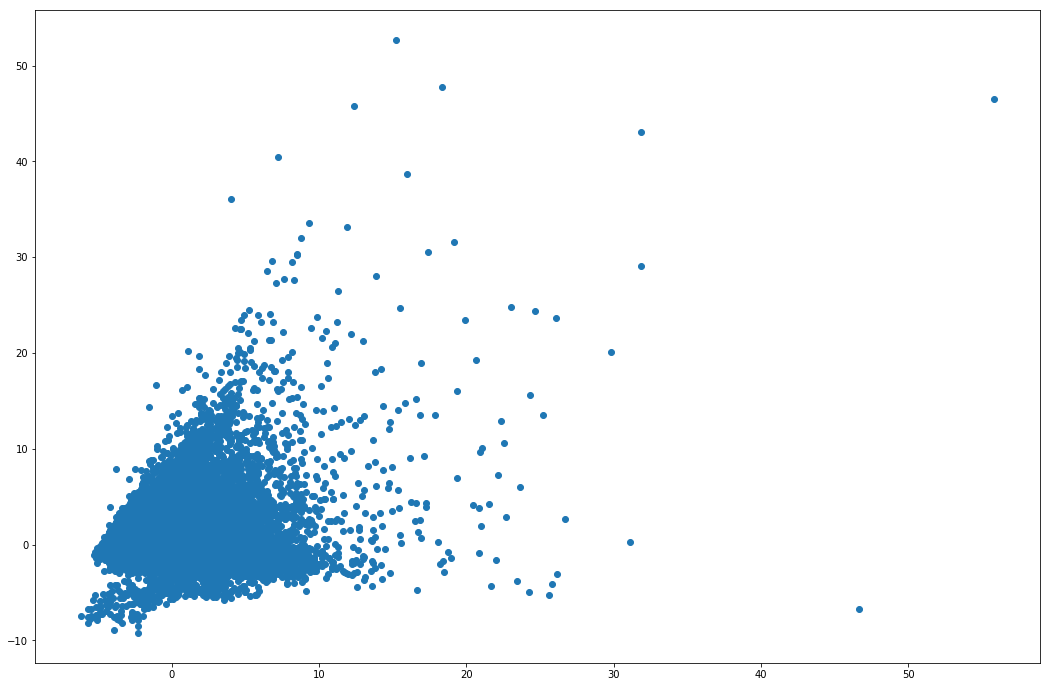

In [4]:
df = data.fillna(0)
target=df.drop(['Code','PartnerID','City','isGoodZB'], axis=1)
target = pd.get_dummies(target, columns = ['Sex','CreditCondition'])
X = StandardScaler().fit_transform(target)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

0.12127135587398395
0.11789288190168198
0.12600500683548227
0.12582304042987869
0.10869725606103861
0.12287959771000673
0.1305611754066994
0.14663570696654674
0.1633636454199886


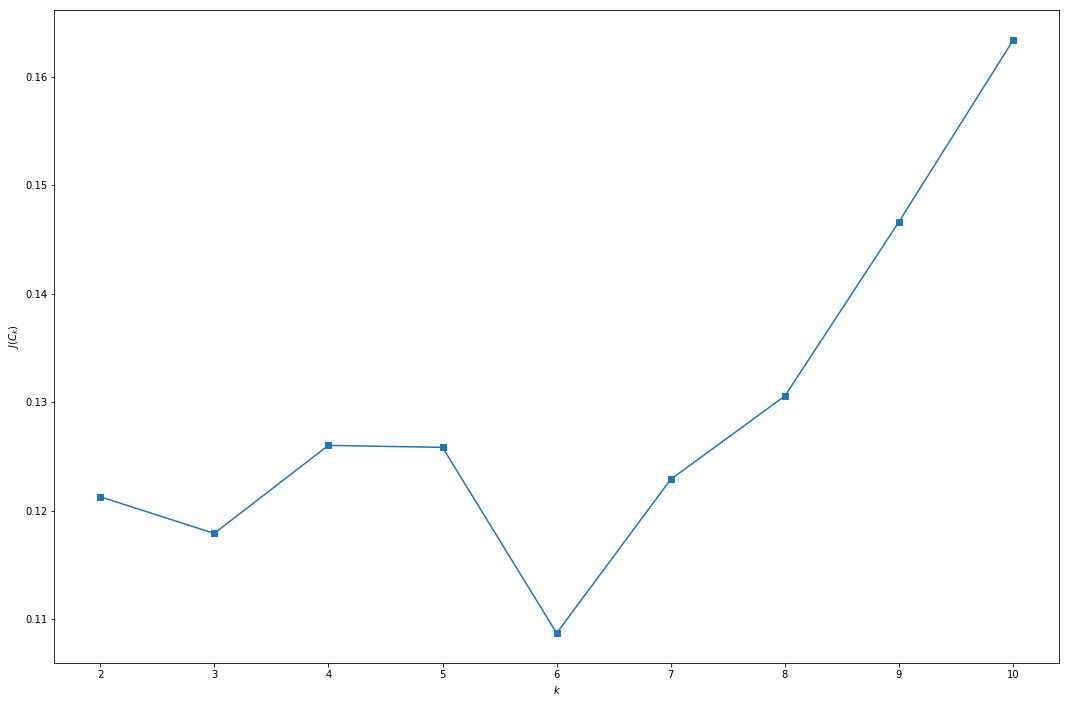

In [5]:
X1 = pd.DataFrame(X).sample(60000)

# с процентами новых и ОСН
from sklearn.metrics import silhouette_score
mas = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=1,n_jobs=-1).fit(X1)
    labels = kmeans.predict(X1)
    #a= silhouette_samples_memory_saving(X1, kmeans.labels_)
    a= silhouette_score(X1, kmeans.labels_)
    mas.append(a)
    print(a)

plt.plot(range(2, 11), mas, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

# Оптимальное количество кластеров 8

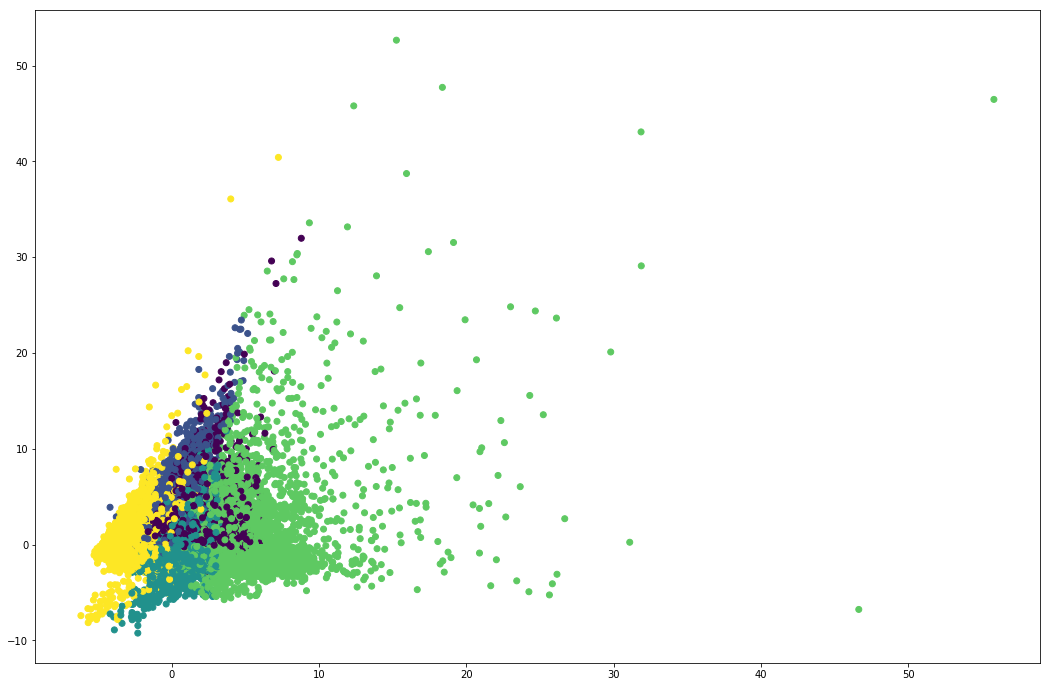

In [6]:
kmeans = KMeans(n_clusters= 5, random_state=1,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [7]:
print(df.shape[0])
print(df[df['labels']==0].shape[0])
print(df[df['labels']==1].shape[0])
print(df[df['labels']==2].shape[0])
print(df[df['labels']==3].shape[0])
print(df[df['labels']==4].shape[0])
#print(df[df['labels']==5].shape[0])
#print(df[df['labels']==6].shape[0])
#print(df[df['labels']==7].shape[0])
#print(df[df['labels']==8].shape[0])
#print(df[df['labels']==9].shape[0])

118651
14703
35289
34444
15119
19096
0
0
0


In [8]:
pd.concat([df[df['labels']==0].describe().T['50%'],df[df['labels']==0].describe().T['mean'],df[df['labels']==0].describe().T['std'], \
           df[df['labels']==1].describe().T['50%'],df[df['labels']==1].describe().T['mean'],df[df['labels']==1].describe().T['std'], \
           df[df['labels']==2].describe().T['50%'],df[df['labels']==2].describe().T['mean'],df[df['labels']==2].describe().T['std'], \
           df[df['labels']==3].describe().T['50%'],df[df['labels']==3].describe().T['mean'],df[df['labels']==3].describe().T['std'], \
           df[df['labels']==4].describe().T['50%'],df[df['labels']==4].describe().T['mean'],df[df['labels']==4].describe().T['std'], \
 #          df[df['labels']==5].describe().T['50%'],df[df['labels']==5].describe().T['mean'],df[df['labels']==5].describe().T['std'], \
 #          df[df['labels']==6].describe().T['50%'],df[df['labels']==6].describe().T['mean'],df[df['labels']==6].describe().T['std'], \
 #          df[df['labels']==7].describe().T['50%'],df[df['labels']==7].describe().T['mean'],df[df['labels']==7].describe().T['std'], \
 #          df[df['labels']==8].describe().T['50%'],df[df['labels']==8].describe().T['mean'],df[df['labels']==8].describe().T['std'], \
 #          df[df['labels']==9].describe().T['50%'],df[df['labels']==9].describe().T['mean'],df[df['labels']==9].describe().T['std'], \
           ],axis=1).to_csv('Client-pre-lastZB-from 2017-2018-2 tolko predZD.csv')